# HVDC Equivalence

This notebook shows how to equivalent a HVDC line using pertubation file.

In [1]:
import andes

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
andes.__version__

'1.9.1.post114.dev0+g4fc9a29d'

In [4]:
andes.config_logger(stream_level=20)

Load the case, but don't set it up as we need add some devices.

In [5]:
ss = andes.load('./ieee14_hvdc.xlsx',
                setup=False,
                no_output=True,
                default_config=True,
                pert='./pert.py')

Working directory: "/Users/jinningwang/work/demo/demo/hvdc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 12 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1009 seconds.
Parsing input file "./ieee14_hvdc.xlsx"...
Input file parsed in 0.1898 seconds.


Inspect transmission lines

In [6]:
ss.Line.as_df()

,idx,u,name,bus1,bus2,Sn,fn,Vn1,Vn2,r,...,g2,trans,tap,phi,rate_a,rate_b,rate_c,owner,xcoord,ycoord
uid,,,,,,,,,,,,,,,,,,,,,
0,Line_1,1,Line_1,1,2,100,60,69,69,0.01938,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
1,Line_2,1,Line_2,1,5,100,60,69,69,0.05403,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
2,Line_3,1,Line_3,2,3,100,60,69,69,0.04699,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
3,Line_4,1,Line_4,2,4,100,60,69,69,0.05811,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
4,Line_5,1,Line_5,2,5,100,60,69,69,0.05695,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
5,Line_6,1,Line_6,3,4,100,60,69,69,0.06701,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
6,Line_7,1,Line_7,4,5,100,60,69,69,0.01335,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
7,Line_8,1,Line_8,6,11,100,60,138,138,0.09498,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None
8,Line_9,1,Line_9,6,12,100,60,138,138,0.12291,...,0,0,1.00000,0,0.0,0.0,0.0,None,None,None


After inspection, `Line_13` does not connect to a generator bus, we can replace it with a HVDC equivalent.

The overall idea is to equivalent the sending end as a load (`PQ`) and equivalend the receiving end as a PV generator (`PV`).
Then we can manipulate the setting parameters to mimic the HVDC line.

First, let's turn the line off.

In [7]:
ss.Line.set(src='u', attr='v', idx='Line_13', value=0)

True

Equivalent the sending end as a load.

In [8]:
ss.add(model='PQ',
       param_dict=dict(idx='CONS', u=1, bus=9,
                       p0=0, q0=0, Vn=138))

'CONS'

Equivalent the receiving end as a generator.

In [9]:
ss.add(model='PV',
       param_dict=dict(idx='CONR', u=1, Sn=ss.config.mva, bus=14,
                       p0=0, q0=0, Vn=138, v0=0.99063,
                       pmax=999, pmin=-999, qmax=999, qmin=-999,
                       ra=0, xs=0.1))

'CONR'

In [10]:
ss.add(model='GENCLS',
       param_dict=dict(idx='CONR', u=1, Sn=ss.config.mva, fn=ss.config.freq,
                       bus=14, gen='CONR', Vn=138,
                       M=0, D=0, ra=0, xl=0, xd1=0,
                       kp=0, kw=0))

'CONR'

Last, let's add a generator trip to observe the system dynamics.

In [11]:
ss.add(model='Toggle',
       param_dict=dict(u=1, model='SynGen',
                       dev='GENROU_3', t=1))

'Toggle_1'

In [12]:
ss.setup()

System internal structure set up in 0.0214 seconds.


True

In [13]:
# use constant power model for PQ, we need to change the power by setting PQ.Ppf
# and it is only effective in constant power mode

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0

# turn off under-voltage PQ-to-Z conversion
ss.PQ.pq2z = 0

In [14]:
ss.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0028 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.00823025234
2: |F(x)| = 7.999336878e-06
3: |F(x)| = 1.807974603e-11
Converged in 4 iterations in 0.0028 seconds.


True

Then, init the TDS.

In [15]:
_ = ss.TDS.init()

Perturbation file "./pert.py" loaded.
GENCLS (vf range) out of typical lower limit.

 idx  | values | limit
------+--------+------
 CONR | 0.991  | 1    


Initialization for dynamics completed in 0.0232 seconds.
Initialization was successful.


Then, we can run the simulation with pertubation.

More details can be found at https://docs.andes.app/en/latest/getting_started/formats/disturbance.html#perturbation-file

In [16]:
ss.TDS.config.criteria = 0  # turn off the criteria check for testing purpose
ss.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-20.0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_1>: SynGen.GENROU_3 status changed to 0 at t=1.0 sec.


Simulation to t=20.00 sec completed in 0.9752 seconds.


True

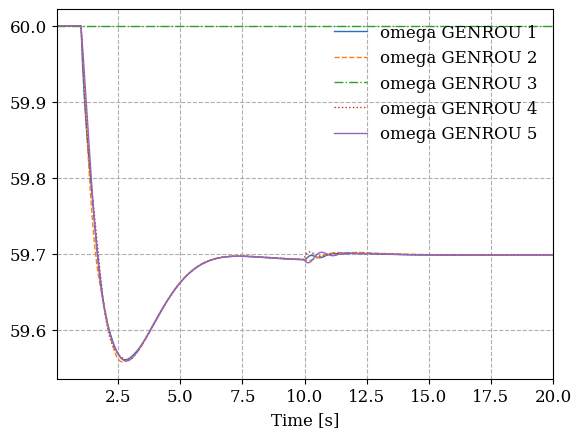

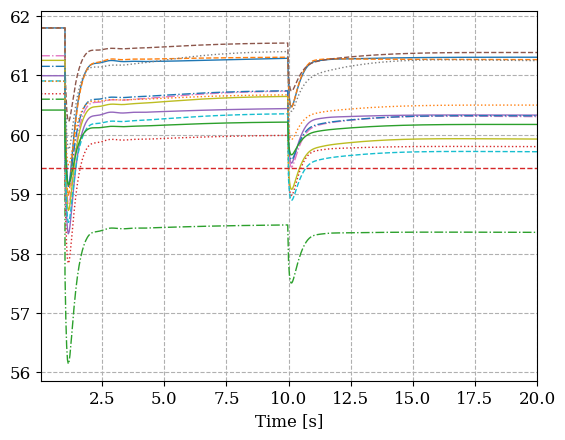

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time [s]'>)

In [17]:
plt.style.use('default')
ss.TDS.plt.plot(ss.GENROU.omega,
                latex=False,
                ytimes=ss.config.freq,
                grid=True)
ss.TDS.plt.plot(ss.Bus.v,
                latex=False,
                ytimes=ss.config.freq,
                grid=True)